In [1]:
# --- 1. Imports ---
import pandas as pd
import numpy as np

# Préprocessing + ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:

df_gdelt = pd.read_csv("/Users/houleyeanne/Documents/FinSent/data/cleaned/gdelt_events_cleaned.csv")
df_api = pd.read_csv("/Users/houleyeanne/Documents/FinSent/data/cleaned/stock_prices_api_cleaned.csv")

In [3]:

# --- 1. Préparer df_api (Yahoo API) ---
df_api = df_api.sort_values("Date").copy()
df_api["Return"] = df_api["Close"].pct_change()  # daily return %
df_api = df_api.dropna()

# --- 2. Préparer df_gdelt (Events) ---
df_gdelt_daily = df_gdelt.groupby("Date").agg({
    "AvgTone": "mean",
    "GoldsteinScale": "mean"
}).reset_index()


df = pd.merge(df_api, df_gdelt_daily, on="Date", how="inner")

df["Target"] = (df["Return"] > 0).astype(int)  # 1 si hausse, 0 si baisse

# --- 5. Features ---
X = df[["Return", "AvgTone", "GoldsteinScale"]]
y = df["Target"]

# --- 6. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# --- 7. Standardisation + Logistic Regression ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# --- 8. Évaluation ---
y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- 9. Coefficients interprétables ---
coeffs = pd.DataFrame({
    "Feature": ["Return", "AvgTone", "GoldsteinScale"],
    "Coefficient": model.coef_[0]
})
print(coeffs)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Confusion Matrix:
[[8 0]
 [0 7]]
          Feature  Coefficient
0          Return     2.396428
1         AvgTone     0.092852
2  GoldsteinScale    -0.078170


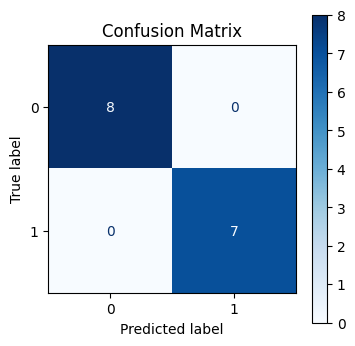

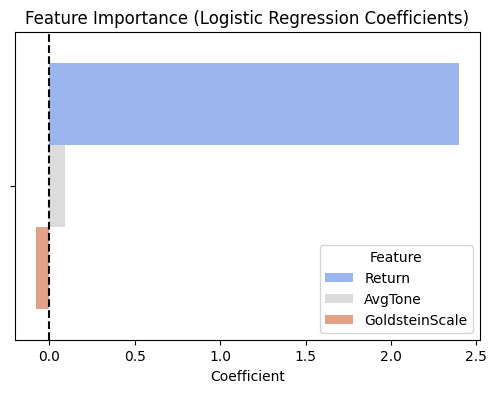

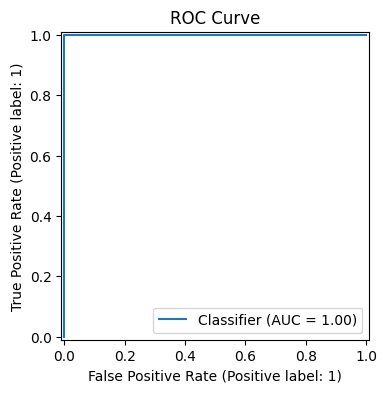

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# --- 1. Confusion Matrix ---
fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", ax=ax)
plt.title("Confusion Matrix")
plt.show()

# --- 2. Feature Importance (bar chart) ---
plt.figure(figsize=(6,4))
sns.barplot(data=coeffs, x="Coefficient", hue="Feature", palette="coolwarm")
plt.axvline(0, color="black", linestyle="--")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()

# --- 3. ROC Curve ---
y_proba = model.predict_proba(X_test_scaled)[:,1]
fig, ax = plt.subplots(figsize=(6,4))
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax)
plt.title("ROC Curve")
plt.show()
